In [25]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from pydantic import BaseModel, Field
import operator

In [26]:
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

In [27]:
model = ChatGoogleGenerativeAI(
    model= "gemini-2.5-flash",
    temperature=1.0,
    max_retries=2,
    google_api_key=api_key,
)
#structured_model = model.with_structured_output(EvaluationSchema)

In [28]:
class EquationState(TypedDict):
    a:int
    b:int
    c:int
    D:float
    equation:str
    result: str

In [29]:
def show_equation(state: EquationState) -> EquationState:
    state['equation'] = f"{state['a']}x^2 + {state['b']}x + {state['c']} = 0"
    return state

def calculate_d(State: EquationState) :
    a = State['a']
    b = State['b']
    c = State['c']
    D = b**2 - 4*a*c
    State['D'] = D
    print(f"Calculated Discriminant (D): {D}")
    return State

def real_roots(state: EquationState) :
    a = state['a']
    b = state['b']
    D = state['D']
    root1 = (-b + D**0.5) / (2*a)
    root2 = (-b - D**0.5) / (2*a)
    return {"result": f"Roots are real and different: {root1}, {root2}"}

def equal_roots(state: EquationState) :
    a = state['a']
    b = state['b']
    root = -b / (2*a)
    return {"result": f"Roots are real and equal: {root}"}

def imaginary_roots(state: EquationState) :
    return {"result": "Roots are imaginary."}

def check_condition(state: EquationState) -> Literal["real_roots", "equal_roots", "imaginary_roots"]:
    D = state['D']
    if D > 0:
        return "real_roots"
    elif D == 0:
        return "equal_roots"
    else:
        return "imaginary_roots"

In [30]:
graph = StateGraph(EquationState)

# add nodes 
graph.add_node("show_equation", show_equation)
graph.add_node("calculate_d", calculate_d)
graph.add_node("real_roots", real_roots)
graph.add_node("equal_roots", equal_roots)
graph.add_node("imaginary_roots", imaginary_roots)

# add edges
graph.add_edge(START, "show_equation")
graph.add_edge("show_equation", "calculate_d")
graph.add_conditional_edges("calculate_d", check_condition)
graph.add_edge("real_roots", END)
graph.add_edge("equal_roots", END)
graph.add_edge("imaginary_roots", END)

# compile graph
workflow = graph.compile()

In [31]:
initial_state = {
    "a":2,
    "b":4,
    "c":2
}
final_state = workflow.invoke(initial_state)
print(final_state)

Calculated Discriminant (D): 0
{'a': 2, 'b': 4, 'c': 2, 'D': 0, 'equation': '2x^2 + 4x + 2 = 0', 'result': 'Roots are real and equal: -1.0'}


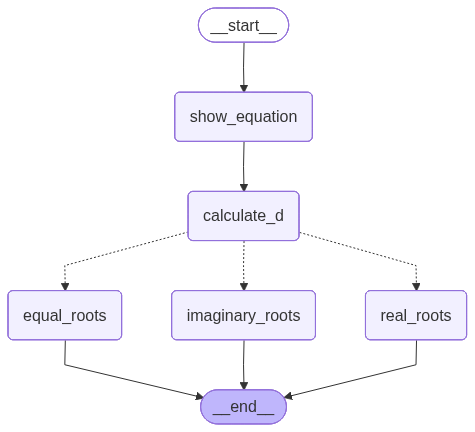

In [32]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())